In [1]:
pip install CacheControl

In [2]:
pip install pyquery

In [3]:
pip install tenacity

In [4]:
pip install umls-api

  Created wheel for umls-api: filename=umls_api-0.1.0-py3-none-any.whl size=3408 sha256=3772556ec50a9bcc199783296497d4166b03962216094c71eeab6e981cb0b0a0
  Stored in directory: /root/.cache/pip/wheels/b1/0c/16/429473df1665cab9602747448f46d5fb701bf2e9634915ea71
Successfully built umls-api


In [5]:
!pip install pyldavis --q

     |████████████████████████████████| 1.7 MB 8.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.5 MB 49.9 MB/s 
     |████████████████████████████████| 15.7 MB 75 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires numpy~=1.19.2, but you have numpy 1.21.1 which is incompatible.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [6]:
pip install stanza

     |████████████████████████████████| 337 kB 7.8 MB/s 


In [1]:
import stanza
stanza.download('en',package = 'craft')

2021-08-03 22:19:15 INFO: Downloading these customized packages for language: en (English)...
| Processor | Package |
-----------------------
| tokenize  | craft   |
| pos       | craft   |
| lemma     | craft   |
| depparse  | craft   |
| pretrain  | craft   |



2021-08-03 22:19:46 INFO: Finished downloading models and saved to /root/stanza_resources.


In [30]:
from gensim.models.coherencemodel import CoherenceModel

In [2]:
import requests
from cachecontrol import CacheControl
import json
from lxml.html import fromstring
import pyquery
import pandas as pd
import umls_api
import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary 

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
from gensim.parsing.preprocessing import strip_numeric,strip_multiple_whitespaces, strip_punctuation, strip_short, strip_tags

In [3]:
import re
import numpy as np

In [4]:
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:169: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('drive/MyDrive/bbc_1807_1906_novideos.csv',encoding = 'utf-8')
df.head

Mounted at /content/drive


<bound method NDFrame.head of      Month  ... Unnamed: 6
0     1901  ...        NaN
1     1901  ...        NaN
2     1901  ...        NaN
3     1901  ...        NaN
4     1901  ...        NaN
..     ...  ...        ...
707   1812  ...        NaN
708   1812  ...        NaN
709   1812  ...        NaN
710   1812  ...        NaN
711   1812  ...        NaN

[712 rows x 7 columns]>

In [6]:
texts = list(df.loc[:, "text"].values)

In [7]:
new_sw = ['people','say','says','said','could','one','would','take','want','have','she','he','give','told','know','but','health','month','day','year', 'minute','second','hundred','thousand','however']
stop_words = STOPWORDS.union(set(new_sw))

In [8]:
pubmed_stoplist = ['a','about','again','all','almost', 'also','although','always',\
                   'among','an','and','another','any','are','as','at','be','because',\
                   'been','before','being','between','both','but','by','can','could',\
                   'did','do','does','done','due','during','each','either','enough', \
                   'especially','etc','for','found', 'from','further','had','is','it',\
                   'has','have','having','here','how','however','i','if','in','into',\
                   'its','itself','just','kg','km', 'made','mainly','make','may','mg',\
                   'might','ml','mm','most','mostly','must','nearly','neither','no',\
                   'nor','obtained','of','often','on','our','overall','perhaps','pmid',\
                   'quite','rather','really','regarding','seem','seen','several',\
                   'should','show','showed','shown','shows','significantly','since',\
                   'so','some','such','than','that','the','their','theirs','them',\
                   'then','there','therefore','these','they','this','those','through',\
                   'thus','to','upon','use','used','using','various','very', 'was','we',\
                   'were','what','when', 'which','while','with','within','without','would']

In [9]:
stop_words = STOPWORDS.union(set(pubmed_stoplist))

In [10]:
clean_article = []

for text in texts:
  #remove new line character and punctuations 
  clean = []
  text = strip_multiple_whitespaces(text)
  text = strip_numeric(text)
  text = strip_punctuation(text)
  text = strip_tags(text)
  text = strip_short(text,minsize=3)
  text = remove_stopwords(text)
  # lower case, de-accents.  Convert the texts into a list of tokens
  for token in gensim.utils.simple_preprocess(text, deacc=True):
      clean.append(token)
  clean_article.append(clean)

In [11]:
nlp_craft = stanza.Pipeline('en',package = 'craft',processor = 'pos,tokenize,lemma',tokenize_pretokenized = True)

2021-08-03 22:20:50 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | craft   |
| pos       | craft   |
| lemma     | craft   |
| depparse  | craft   |

2021-08-03 22:20:50 INFO: Use device: gpu
2021-08-03 22:20:50 INFO: Loading: tokenize
2021-08-03 22:20:50 INFO: Loading: pos
2021-08-03 22:21:02 INFO: Loading: lemma
2021-08-03 22:21:02 INFO: Loading: depparse
2021-08-03 22:21:02 INFO: Done loading processors!


In [12]:
doc_craft = nlp_craft (clean_article)

In [13]:
token_list = []
for i in range(len(doc_craft.sentences)):
  article_token_list = []
  for m in range(len(doc_craft.sentences[i].tokens)):
    article_token_list.append(doc_craft.sentences[i].words[m].lemma)
  token_list.append(article_token_list)


In [14]:
print(token_list[0])

['the', 'cheese', 'addict', 'but', 'discover', 'recently', 'shake', 'core', 'barely', 'look', 'babybel', 'face', 'half', 'eat', 'halloumi', 'squeaklessly', 'lie', 'yellow', 'fridge', 'cheese', 'dream', 'shatter', 'for', 'lifetime', 'unfettered', 'devotion', 'possibly', 'cheese', 'foe', 'friend', 'that', 'addict', 'good', 'body', 'that', 'cheese', 'toast', 'these', 'question', 'begin', 'surface', 'couple', 'month', 'ago', 'begin', 'make', 'episode', 'new', 'podcast', 'bbc', 'all', 'hail', 'kale', 'look', 'dairy', 'scary', 'for', 'time', 'increasingly', 'question', 'logic', 'adult', 'drink', 'milk', 'while', 'milk', 'dairy', 'product', 'cheese', 'yoghurt', 'good', 'source', 'protein', 'calcium', 'form', 'healthy', 'balance', 'diet', 'michael', 'greger', 'nutritionfact', 'org', 'there', 'animal', 'planet', 'drink', 'milk', 'weaning', 'drink', 'milk', 'species', 'sense', 'reel', 'series', 'study', 'show', 'life', 'shortening', 'potential', 'drink', 'hormonal', 'stew', 'blithely', 'assume',

In [15]:
bigram = gensim.models.Phrases(token_list, min_count=5, threshold=100) 
bigram_2 = gensim.models.phrases.Phraser(bigram)
bigram_words = [bigram_2[text] for text in token_list]

In [16]:
print(bigram_words[0])

['the', 'cheese', 'addict', 'but', 'discover', 'recently', 'shake', 'core', 'barely', 'look', 'babybel', 'face', 'half', 'eat', 'halloumi', 'squeaklessly', 'lie', 'yellow', 'fridge', 'cheese', 'dream', 'shatter', 'for', 'lifetime', 'unfettered', 'devotion', 'possibly', 'cheese', 'foe', 'friend', 'that', 'addict', 'good', 'body', 'that', 'cheese', 'toast', 'these', 'question', 'begin', 'surface', 'couple', 'month', 'ago', 'begin', 'make', 'episode', 'new', 'podcast', 'bbc', 'all', 'hail', 'kale', 'look', 'dairy', 'scary', 'for', 'time', 'increasingly', 'question', 'logic', 'adult', 'drink', 'milk', 'while', 'milk', 'dairy', 'product', 'cheese', 'yoghurt', 'good', 'source', 'protein', 'calcium', 'form', 'healthy', 'balance', 'diet', 'michael', 'greger', 'nutritionfact', 'org', 'there', 'animal', 'planet', 'drink', 'milk', 'weaning', 'drink', 'milk', 'species', 'sense', 'reel', 'series', 'study', 'show', 'life', 'shortening', 'potential', 'drink', 'hormonal', 'stew', 'blithely', 'assume',

In [17]:
apikey = "e22b627f-226b-420b-9de2-935e10ff3350"
service="http://umlsks.nlm.nih.gov"

In [18]:
def get_granting_ticket():
     params = {'apikey': apikey}
     h = {"Content-type": "application/x-www-form-urlencoded", "Accept": "text/plain", "User-Agent":"python" }
     r = requests.post("https://utslogin.nlm.nih.gov/cas/v1/api-key",data=params,headers=h)
     response = fromstring(r.text)
     tgt = response.xpath('//form/@action')[0]
     return tgt

In [19]:
def get_single_ticket(tgt):
     params = {'service': service}
     h = {"Content-type": "application/x-www-form-urlencoded", "Accept": "text/plain", "User-Agent":"python" }
     r = requests.post(tgt,data=params,headers=h)
     st = r.text
     return st

In [20]:
tgt = get_granting_ticket()

def term_type(string,tgt):
  version = "2021AA"
  string = string
  pageNumber=0

  while True:
    ##generate a new service ticket for each page if needed
    ticket = get_single_ticket(tgt)
    pageNumber += 1
    query = {'string':string,'ticket':ticket, 'pageNumber':pageNumber}
    session = requests.session()
    cache = CacheControl(session)
    
    r = session.get("https://uts-ws.nlm.nih.gov/rest/search/"+version,params=query)
    r.encoding = 'utf-8'
    items  = json.loads(r.text)
    jsonData = items["result"]
    
    if jsonData["results"][0]["ui"] != "NONE":
      # ui_list = []
      # for result in jsonData["results"]:
      #   r = umls_api.API(api_key = 'e22b627f-226b-420b-9de2-935e10ff3350').get_cui(cui = result["ui"])['result']['semanticTypes'][0]['name']
      #   ui_list.append(r)
      # # if 'Temporal Concept' or 'Qualitative Concept' or 'Quantitative Concept' in ui_list:
      # #   return False
      # # else:  
      return True        
    
    if jsonData["results"][0]["ui"] == "NONE":
      return False 
      

In [21]:
umls_list = []
for article in bigram_words[:10]:
  print ("-----------")
  article_umls_list =[]
  for word in article:
    umls = term_type(word,tgt)
    if umls is True:
      print(word)
      article_umls_list.append(word)
  umls_list.append(article_umls_list)

print(umls_list[0])
#40mins for 10 articles

-----------
cheese
addict
discover
recently
shake
core
barely
look
face
half
eat
lie
yellow
cheese
dream
lifetime
devotion
possibly
cheese
foe
friend
addict
good
body
cheese
toast
question
begin
surface
couple
month
ago
begin
make
episode
new
podcast
bbc
all
hail
kale
look
dairy
scary
time
increasingly
question
logic
adult
drink
milk
while
milk
dairy
product
cheese
yoghurt
good
source
protein
calcium
form
healthy
balance
diet
michael
org
animal
planet
drink
milk
weaning
drink
milk
species
sense
reel
series
study
show
life
shortening
potential
drink
hormonal
stew
assume
cheese
mature
benign
beneficial
form
dairy
fit
mental
picture
long
live
greek
italian
liberally
sprinkle
feta
reality
low
moderate
cheese
figure
unilaterally
decide
childhood
diagnosis
lactose
intolerance
way
impede
mainlining
india
ski
spending
time
fork
bread
fondue
bother
slope
perhaps
sense
denial
cum
delusion
stem
actual
addiction
one
doctor
support
professor
speak
refer
cheese
dairy
crack
apparently
contain
addicti

Remove common and rare words

In [22]:
dictionary = Dictionary (umls_list)

In [23]:
dictionary.filter_extremes(no_below=5, no_above=0.7)

Build bag of words 

In [24]:
corpus = [dictionary.doc2bow(text) for text in umls_list]

In [25]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 35
Number of documents: 10


In [26]:
# Human readable format of corpus (term-frequency)
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('bbc', 2),
  ('body', 1),
  ('carry', 1),
  ('day', 3),
  ('decide', 1),
  ('get', 1),
  ('give', 1),
  ('go', 1),
  ('have', 3),
  ('health', 2),
  ('know', 2),
  ('like', 3),
  ('long', 1),
  ('look', 2),
  ('new', 1),
  ('programme', 1),
  ('recommend', 1),
  ('result', 1),
  ('school', 1),
  ('see', 1),
  ('she', 1),
  ('source', 1),
  ('tell', 1),
  ('think', 5),
  ('time', 2),
  ('way', 1)]]

# TFIDF

In [27]:
tfidf =  gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
for i in corpus_tfidf[0]:
  print(i)

(0, 0.31442445919702755)
(1, 0.15721222959851378)
(2, 0.11586000419626274)
(3, 0.34758001258878823)
(4, 0.08089719579214767)
(5, 0.15721222959851378)
(6, 0.11586000419626274)
(7, 0.15721222959851378)
(8, 0.34758001258878823)
(9, 0.16179439158429534)
(10, 0.16179439158429534)
(11, 0.242691587376443)
(12, 0.08089719579214767)
(13, 0.2317200083925255)
(14, 0.15721222959851378)
(15, 0.15721222959851378)
(16, 0.11586000419626274)
(17, 0.15721222959851378)
(18, 0.11586000419626274)
(19, 0.15721222959851378)
(20, 0.11586000419626274)
(21, 0.15721222959851378)
(22, 0.11586000419626274)
(23, 0.4044859789607383)
(24, 0.16179439158429534)
(25, 0.11586000419626274)


In [28]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=2, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.043*"help" + 0.042*"know" + 0.041*"result" + 0.035*"give" + 0.033*"like" + 0.033*"new" + 0.033*"think" + 0.031*"world" + 0.031*"day" + 0.030*"carry"
Topic: 1 Word: 0.073*"child" + 0.045*"family" + 0.045*"parent" + 0.040*"day" + 0.039*"tell" + 0.038*"feel" + 0.035*"use" + 0.034*"time" + 0.033*"when" + 0.033*"body"


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [32]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_tfidf.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_ldatfidf = CoherenceModel(model=lda_model_tfidf, texts=umls_list, dictionary=dictionary, coherence='c_v')
coherence_ldatfidf = coherence_model_ldatfidf.get_coherence()
print('\nCoherence Score: ', coherence_ldatfidf)


Perplexity:  -3.9304395828283196

Coherence Score:  0.2579875689898259


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [33]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model_tfidf, corpus, dictionary)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.010447  0.0       1        1  86.470376
0     -0.010447  0.0       2        1  13.529624, topic_info=      Term       Freq      Total Category  logprob  loglift
29    help  12.000000  12.000000  Default  30.0000  30.0000
10    know  15.000000  15.000000  Default  29.0000  29.0000
17  result  11.000000  11.000000  Default  28.0000  28.0000
6     give  14.000000  14.000000  Default  27.0000  27.0000
14     new  13.000000  13.000000  Default  26.0000  26.0000
..     ...        ...        ...      ...      ...      ...
3      day   2.190815  20.330740   Topic2  -3.4845  -0.2276
31    when   1.531844  16.710423   Topic2  -3.8423  -0.3893
30  parent   1.809175  22.354113   Topic2  -3.6759  -0.5139
26   child   2.135901  35.377375   Topic2  -3.5099  -0.8069
28  family   1.713581  22.289759   Topic2  -3.7302  -0.5653

[95 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.846740    bbc
0         2  0.169348    bbc
1         1  0.874699   body
1         2  0.116627   body
2         1  0.821532  carry
...     ...       ...    ...
25        2  0.189048    way
31        1  0.897643   when
31        2  0.119686   when
32        1  0.844024  world
32        2  0.168805  world

[70 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

## Find optimal number of topics 

In [34]:
coherence_values = []
model_list = []
for num_topics in range(2, 6, 1):
    model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=num_topics, id2word=dictionary, workers=2, passes=2, iterations = 100)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=umls_list, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [35]:
# Print the coherence scores
for m, cv in zip(range(2,6,1), coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2801
Num Topics = 3  has Coherence Value of 0.2343
Num Topics = 4  has Coherence Value of 0.2318
Num Topics = 5  has Coherence Value of 0.2476


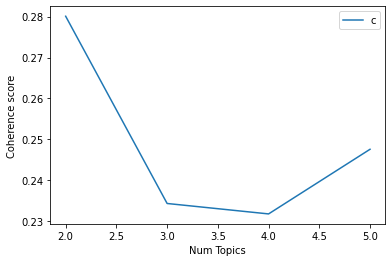

In [36]:
# Show graph
plt.plot(range(2,6,1), coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Optimal Model


In [38]:
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(0, '0.045*"know" + 0.041*"help" + 0.040*"body" + 0.038*"child" + 0.038*"result" + 0.037*"give" + 0.034*"world" + 0.033*"use" + 0.033*"new" + 0.032*"like"'), (1, '0.070*"child" + 0.049*"parent" + 0.049*"day" + 0.045*"family" + 0.037*"tell" + 0.036*"time" + 0.035*"when" + 0.033*"use" + 0.031*"recommend" + 0.030*"feel"')]


In [39]:
pyLDAvis.gensim_models.prepare(optimal_model, corpus, dictionary)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.010965  0.0       1        1  69.670951
0     -0.010965  0.0       2        1  30.329049, topic_info=         Term       Freq      Total Category  logprob  loglift
10       know  15.000000  15.000000  Default  30.0000  30.0000
29       help  13.000000  13.000000  Default  29.0000  29.0000
17     result  13.000000  13.000000  Default  28.0000  28.0000
1        body  14.000000  14.000000  Default  27.0000  27.0000
32      world  11.000000  11.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
16  recommend   3.128178  14.657614   Topic2  -3.9356  -0.3514
26      child   6.124951  31.807004   Topic2  -3.2637  -0.4543
28     family   4.216878  20.878825   Topic2  -3.6369  -0.4066
30     parent   3.834709  21.734438   Topic2  -3.7319  -0.5417
3         day   3.635135  21.477806   Topic2  -3.7854  -0.5833

[96 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.769414    bbc
0         2  0.230824    bbc
1         1  0.601543   body
1         2  0.401028   body
2         1  0.595399  carry
...     ...       ...    ...
25        2  0.348894    way
31        1  0.799664   when
31        2  0.184538   when
32        1  0.509214  world
32        2  0.424345  world

[70 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [40]:
# Compute Perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_ldatfidf = CoherenceModel(model=optimal_model, texts=umls_list, dictionary=dictionary, coherence='c_v')
coherence_ldatfidf = coherence_model_ldatfidf.get_coherence()
print('\nCoherence Score: ', coherence_ldatfidf)


Perplexity:  -3.954378160111832

Coherence Score:  0.2800929002502262


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for


## -----------------------Rewrite 




# Dominant topic in each sentence 

In [41]:
def format_topics_sentences(ldamodel=lda_model_tfidf, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.5123,"child, parent, day, family, tell, time, when, ...",My name is Tim and I'm a cheese addict. But wh...
1,1,1.0,0.9774,"child, parent, day, family, tell, time, when, ...",Children in the UK exceed the maximum recommen...
2,2,0.0,0.9747,"know, help, body, child, result, give, world, ...",A clinical trial has been launched to see if a...
3,3,1.0,0.9789,"child, parent, day, family, tell, time, when, ...",When 12-year-old Matthew Carter saw how much s...
4,4,0.0,0.5329,"know, help, body, child, result, give, world, ...",When Jessica Share bought sperm from a sperm b...
5,5,0.0,0.9608,"know, help, body, child, result, give, world, ...",Scientists have found the most likely source o...
6,6,0.0,0.9675,"know, help, body, child, result, give, world, ...",A month-long campaign encouraging women to gro...
7,7,1.0,0.9915,"child, parent, day, family, tell, time, when, ...",There is little evidence screen use for childr...
8,8,1.0,0.9634,"child, parent, day, family, tell, time, when, ...",Authorities investigating the death of an 11-y...
9,9,1.0,0.9910,"child, parent, day, family, tell, time, when, ...",New guidance from the Royal College of Paediat...


# Find the most representative document for each topic

In [42]:
# Group top 5 sentences under each topic
sent_topics_sorteddf= pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9747,"know, help, body, child, result, give, world, ...",A clinical trial has been launched to see if a...
1,1.0,0.9915,"child, parent, day, family, tell, time, when, ...",There is little evidence screen use for childr...


## Topic distribution across documents

In [43]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,1.0,"child, parent, day, family, tell, time, when, ...",4.0,0.4
1.0,1.0,"child, parent, day, family, tell, time, when, ...",6.0,0.6
2.0,0.0,"know, help, body, child, result, give, world, ...",NaN,NaN
3.0,1.0,"child, parent, day, family, tell, time, when, ...",NaN,NaN
4.0,0.0,"know, help, body, child, result, give, world, ...",NaN,NaN
...,...,...,...,...
707.0,NaN,NaN,NaN,NaN
708.0,NaN,NaN,NaN,NaN
709.0,NaN,NaN,NaN,NaN
710.0,NaN,NaN,NaN,NaN


# Trigram 

In [44]:
trigram = gensim.models.Phrases(bigram[bigram_words], threshold=100) 
trigram_2 = gensim.models.phrases.Phraser(trigram)
trigram_words = [trigram_2[text] for text in umls_list]

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [45]:
# Create Dictionary
dictionary_trigram = Dictionary(trigram_words)
dictionary_trigram.filter_extremes(no_below=5, no_above=0.7)

# Create Corpus
corpus_trigram = [dictionary_trigram.doc2bow(text) for text in trigram_words]
print('Number of unique tokens: %d' % len(dictionary_trigram))
print('Number of documents: %d' % len(corpus_trigram))

# Term Document Frequency
corpus_trigram = [dictionary_trigram.doc2bow(text) for text in trigram_words]

# View
print(corpus_trigram[:1])

Number of unique tokens: 35
Number of documents: 10
[[(0, 2), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 1), (8, 3), (9, 2), (10, 2), (11, 3), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 5), (24, 2), (25, 1)]]


In [46]:
[[(dictionary_trigram[id], freq) for id, freq in cp] for cp in corpus_trigram[:1]]

[[('bbc', 2),
  ('body', 1),
  ('carry', 1),
  ('day', 3),
  ('decide', 1),
  ('get', 1),
  ('give', 1),
  ('go', 1),
  ('have', 3),
  ('health', 2),
  ('know', 2),
  ('like', 3),
  ('long', 1),
  ('look', 2),
  ('new', 1),
  ('programme', 1),
  ('recommend', 1),
  ('result', 1),
  ('school', 1),
  ('see', 1),
  ('she', 1),
  ('source', 1),
  ('tell', 1),
  ('think', 5),
  ('time', 2),
  ('way', 1)]]

In [47]:
tfidf_trigram =  gensim.models.TfidfModel(corpus_trigram)
corpus_tfidf_trigram = tfidf_trigram[corpus_trigram]
for i in corpus_tfidf_trigram[0]:
  print(i)

(0, 0.31442445919702755)
(1, 0.15721222959851378)
(2, 0.11586000419626274)
(3, 0.34758001258878823)
(4, 0.08089719579214767)
(5, 0.15721222959851378)
(6, 0.11586000419626274)
(7, 0.15721222959851378)
(8, 0.34758001258878823)
(9, 0.16179439158429534)
(10, 0.16179439158429534)
(11, 0.242691587376443)
(12, 0.08089719579214767)
(13, 0.2317200083925255)
(14, 0.15721222959851378)
(15, 0.15721222959851378)
(16, 0.11586000419626274)
(17, 0.15721222959851378)
(18, 0.11586000419626274)
(19, 0.15721222959851378)
(20, 0.11586000419626274)
(21, 0.15721222959851378)
(22, 0.11586000419626274)
(23, 0.4044859789607383)
(24, 0.16179439158429534)
(25, 0.11586000419626274)


In [48]:
lda_model_trigram = gensim.models.LdaMulticore(corpus_tfidf_trigram, num_topics=2, id2word=dictionary_trigram, workers=2, passes=2, iterations = 100)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [49]:
print(lda_model_trigram.print_topics())

[(0, '0.077*"child" + 0.053*"parent" + 0.047*"use" + 0.044*"family" + 0.044*"time" + 0.043*"day" + 0.033*"when" + 0.031*"recommend" + 0.030*"see" + 0.029*"health"'), (1, '0.040*"know" + 0.039*"body" + 0.038*"give" + 0.036*"tell" + 0.036*"new" + 0.036*"help" + 0.036*"like" + 0.035*"feel" + 0.034*"result" + 0.034*"child"')]


In [50]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_trigram.log_perplexity(corpus_trigram))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_tri = CoherenceModel(model=lda_model_trigram, texts=trigram_words, dictionary=dictionary_trigram, coherence='c_v')
coherence_lda_tri = coherence_model_lda_tri.get_coherence()
print('\nCoherence Score: ', coherence_lda_tri)


Perplexity:  -3.9183395712664635

Coherence Score:  0.28578065394822055


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [51]:
pyLDAvis.gensim_models.prepare(lda_model_trigram, corpus_trigram, dictionary_trigram)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.012938  0.0       1        1  55.265461
1     -0.012938  0.0       2        1  44.734539, topic_info=         Term       Freq      Total Category  logprob  loglift
26      child  30.000000  30.000000  Default  30.0000  30.0000
6        give  15.000000  15.000000  Default  29.0000  29.0000
14        new  14.000000  14.000000  Default  28.0000  28.0000
30     parent  20.000000  20.000000  Default  27.0000  27.0000
1        body  15.000000  15.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
16  recommend   4.887718  13.901301   Topic2  -3.8779  -0.2408
28     family   6.709737  19.645945   Topic2  -3.5611  -0.2699
26      child   7.971571  30.438501   Topic2  -3.3888  -0.5354
30     parent   5.106577  20.560253   Topic2  -3.8341  -0.5884
24       time   4.921019  17.768137   Topic2  -3.8712  -0.4795

[97 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.551399    bbc
0         2  0.393856    bbc
1         1  0.439113   body
1         2  0.564574   body
2         1  0.556884  carry
...     ...       ...    ...
25        2  0.583814    way
31        1  0.657416   when
31        2  0.394449   when
32        1  0.460963  world
32        2  0.537790  world

[70 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

## Find optimal number of topics 

In [ ]:
# coherence_values_trigram = []
# model_list_trigram= []
# for num_topics in range(2, 20, 2):
#     model_trigram = gensim.models.LdaMulticore(corpus_tfidf_trigram, num_topics=num_topics, id2word=dictionary_trigram, workers=2, passes=2, iterations = 100)
#     model_list_trigram.append(model_trigram)
#     coherencemodel_trigram = CoherenceModel(model=model_trigram, texts=lemmatized_list, dictionary=dictionary_trigram, coherence='c_v')
#     coherence_values_trigram.append(coherencemodel_trigram.get_coherence())

In [ ]:
# Print the coherence scores
# for m, cv in zip(range(2,20,2), coherence_values_trigram):
#     print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# Show graph
# plt.plot(range(2,20,2), coherence_values_trigram)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()